# Final project in course Machine Learning in Astronomy

Authors:

- Giorgos Galanaquis 

- Matias Hendolin

## 1. Introduction

In this Final project we will be exploring simulated data provided by a Kaggle comptetition about classifying astronomical sources according to their light curves, i.e. the photometric time-series data. Here we provide a link to the Kaggle competition: https://www.kaggle.com/competitions/PLAsTiCC-2018/overview. Also for further reading, the competition provides the following article: https://arxiv.org/abs/1810.00001.

The provided data consists of metadata and the time-series photometric data. The metadata contains for instance coordinates, redshifts and the target class of the sources. The time-series data consists of flux calculations and errors on different bands with different observation time stamps.

The training metadata and photometric data are linked with object identificator (object_id). We should note, that in the metadata, every source has only one row of data, i.e. one value for each feature, whereas in the photometric data, every source has several rows of data for different passbands at different timestamps of measurement.

Also, the competition provides some caveats about the data. We add the caveats here as a directed reference and therefore notated with the reference symbols "":

### Caveats

"A few caveats about the light-curve data are as follows:

- Data gaps: Different passbands are taken at different times, sometimes many days apart.

- Galactic vs extragalactic: The given redshift for objects in our own galaxy is given as zero.

- Negative Flux: Due to statistical fluctuations (of e.g. the sky brightness) and the way the brightness is estimated, the flux may be negative for dim sources, where the true flux is close to zero. Second, if the pre-survey image actually contains a flux brighter than its true ‘zero’, this can lead to a negative flux when the difference is computed."

## 2. Loading the data

Plan:

Load the data in to metadata and data tables. Do the preliminary analysis of the data and their distribution. We need features and labels for the training. The labels are in the metadata and the time-varying fluxes are in the data table. We might also use the photom_z and distmod from the metadata to teach the model, but first check if others have done that, or only used the light curves. If only light curves, take the ID and label and connect those to the light curves data when fitting the model.

For instance the following implementation https://www.kaggle.com/code/mustfain/plastic separates the data into galactic and extra-galactic data sets to train a model for each separately, creates new features which are groupings of data, taking means and some extreme cases etc. - not probably necessary for us pedagogically. But it combines the metadata and time-series data to have for the training features also the redshifts. Note, that not all of the sources have the spectroscopic redshift, only the photometric. That is why the person has two cases in the code to take this into account, and apparently, he merged the redshifts so that if the source did not have the spectroscopic redshift, for the training data the photometric redshift was used.

Therefore, for us, I think we should combine the redshifts as explained above, so that every source has one, we should combine those redshifts to the time-series data as another feature and train a decision tree, random forest or a lightgmb with those features. So no need for MJD, even though the guy created a new feature depending on the observation period and something related to variability related to the flux with the time stamp information. We should stick to the flux itself on different bands and the redshift, because they are the clearest markers: flux on a band of course tells about the thermal phenomena and physical phenomena and then the redshift tells about the distance and location in the universe. Therefore, with these two, combined to the known labels, we should be able to classify the sources.

Let us first import the libraries and load the metadata and time-series data into data frames.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, model_selection
from sklearn.preprocessing import StandardScaler
#import lightgbm as lgb
import gc
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, accuracy_score

In [10]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set random seed for reproducibility
np.random.seed(42)

In [13]:
# Define column data types for efficient memory usage
col_dict = {
    'mjd': np.float64, 
    'flux': np.float32, 
    'flux_err': np.float32, 
    'object_id': np.int32, 
    'passband': np.int8,
    'detected': np.int8
}

In [16]:
# Load the datasets
train_meta = pd.read_csv('training_set_metadata.csv')
train_lc = pd.read_csv('training_set.csv', dtype=col_dict)

print(f"Loaded {train_meta.shape[0]:,} objects with {train_lc.shape[0]:,} observations")
print(f"Dataset covers {train_meta['target'].nunique()} astronomical classes")

Loading training data...
Loaded 7,848 objects with 1,421,705 observations
Dataset covers 14 astronomical classes


In [26]:
# Display first ten rows of data
display(train_meta.head(10))
display(train_lc.head(10))

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90
5,1227,35.683594,-5.379379,171.992947,-59.253501,1,0.0000,0.0000,0.0000,NaN,0.020,65
6,1598,347.846710,-64.760857,318.929827,-49.143596,1,0.1352,0.1820,0.0304,39.7279,0.019,90
7,1632,348.595886,-63.072620,320.023289,-50.713060,1,0.6857,0.7014,0.0100,43.1524,0.021,42
8,1920,149.414062,3.433834,234.919132,42.245550,1,0.3088,0.3229,0.3360,41.1401,0.027,90
9,1926,149.414062,1.940072,236.565366,41.393323,1,0.0000,0.0000,0.0000,NaN,0.018,65


,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1
5,615,59752.4147,1,-1061.457031,6.472994,1
6,615,59752.4224,3,-524.954590,3.552751,1
7,615,59752.4334,4,-393.480225,3.599346,1
8,615,59752.4435,5,-355.886780,10.421921,1
9,615,59767.2968,2,-548.013550,3.462291,1


We note how the first ten rows of metadata consist of different sources, i.e. every row is a different row, whilst in the light curve data all of the ten rows are data from one source but with different time stamps and on different bands. The sources of training metadata and photometric data are connected with the object identificator column (object_id).

The training metadata (feature column name is written in brackets) for the sources consists of coordinates (equatorial and galactic; decl, gal_l and gal_b), whether the measurement is included in the DDF survey area (flux is more accurate; ddf) host galaxy's spectrometric and photometric redshifts (hostgal_specz, hostgal_photoz), the error of the photometric redshift (hostgal_photoz_err), distance to the source (distmod), Milky Way extinction in the line of sight (mwebv) and the target class (a number, not a string, assigned to an astronomical source class, e.g. 67; target), that the model is taught with and which the model tries to predict for the test set.

The training photometric data of the sources consists of the time of measurement (in MJD; mjd), the ugrizY band on which the measurement was done (represented by a number as u, g, r, i, z, Y = 0, 1, 2, 3, 4, 5; passband), the flux on that band (flux), its error (flux_err) and weather the measured brightness at 3-sigma level significantly differs that of a reference value (detected).

## 3. Preliminary data analysis

In this section we investigate the data and plot distributions. We try to make conclusions about the data that would help us in the design of the models.

In [6]:
# Display the target class distribution
print("Target class distribution:")
class_counts = train_meta['target'].value_counts().sort_index()
print(class_counts)

Target class distribution:
target
6      151
15     495
16     924
42    1193
52     183
53      30
62     484
64     102
65     981
67     208
88     370
90    2313
92     239
95     175
Name: count, dtype: int64


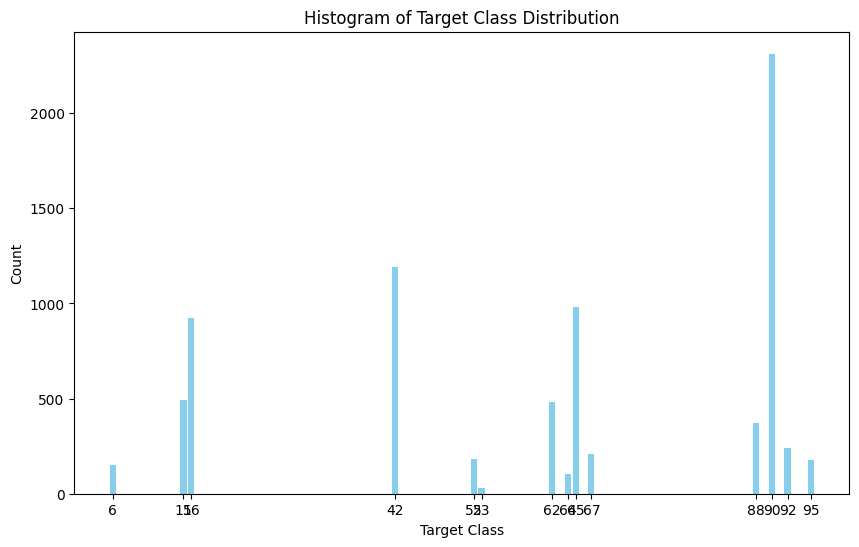

In [9]:
# Plot histogram of target class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.title('Histogram of Target Class Distribution')
plt.xticks(class_counts.index)
plt.show()

Let's see if all data have the redshift of both the photometric and spectrometric.

In [36]:
# Count nulls and NaNs in 'hostgal_photoz' and 'hostgal_specz' columns
null_counts = train_meta[['hostgal_photoz', 'hostgal_specz']].isnull().sum()
nan_counts = train_meta[['hostgal_photoz', 'hostgal_specz']].isna().sum()

print("Null counts:")
print(null_counts)

print("NaN counts:")
print(nan_counts)

Null counts:
hostgal_photoz    0
hostgal_specz     0
dtype: int64
NaN counts:
hostgal_photoz    0
hostgal_specz     0
dtype: int64


Since the sources in our galaxy were given the value 0 to redshift, we plot how many zeros and non-zeros, i.e. galactic and extra-galactic sources, we have in the data.

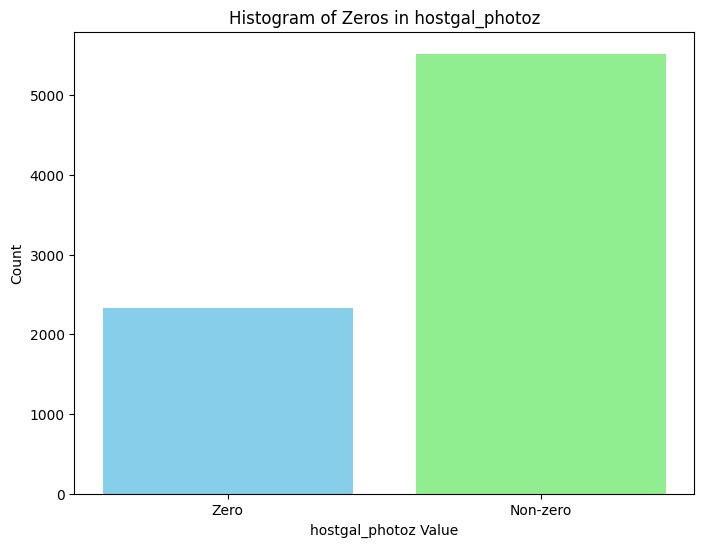

In [30]:
# Count the number of zeros in the 'hostgal_photoz' column
zero_count = (train_meta['hostgal_photoz'] == 0).sum()
non_zero_count = (train_meta['hostgal_photoz'] != 0).sum()

# Create a histogram plot
plt.figure(figsize=(8, 6))
plt.bar(['Zero', 'Non-zero'], [zero_count, non_zero_count], color=['skyblue', 'lightgreen'])
plt.title('Histogram of Zeros in hostgal_photoz')
plt.xlabel('hostgal_photoz Value')
plt.ylabel('Count')
plt.show()

Let us plot the mean of each target class photometric and spectrometric redshifts. We use the catplot, which shows the mean of the target class and the confidence interval around it.

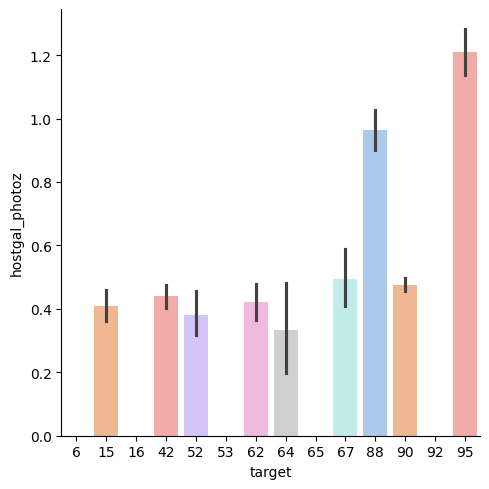

In [29]:
sns.catplot(data=train_meta, x="target", y="hostgal_photoz", kind="bar",palette="pastel")

/tmp/ipykernel_47/1396417357.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=train_meta, x="target", y="hostgal_specz", kind="bar",palette="pastel")


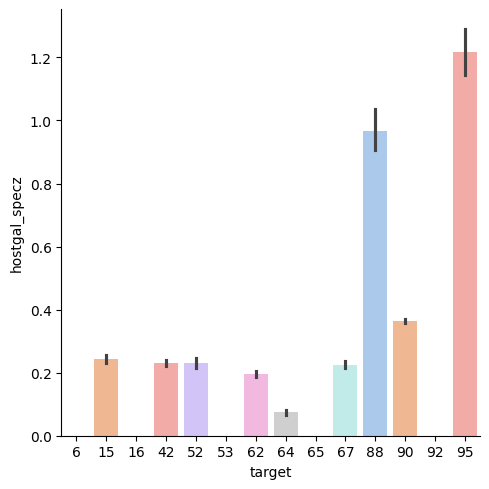

In [9]:
sns.catplot(data=train_meta, x="target", y="hostgal_specz", kind="bar",palette="pastel")

We note, how target classes 6, 16, 53, 65 and 92 are classes that have a redshift of zero. Also, classes 88 and 95 have clearly greater redshifts than others, which would imply that they are sources very far away. 

## 4. Choosing and training the model